In [1]:
import wandb, torch
from ddpm_conditional import *
from fastcore.all import *

# Generation

Let's use the best model to generate samples

In [11]:
model_artifact = 'capecape/train_sd/model:v33'
DEVICE = torch.device('cpu')
run = wandb.init()
artifact = run.use_artifact(model_artifact, type='model')
artifact_dir = artifact.download()
model_cpkt_path = Path(artifact_dir)
model_cpkt_path

wandb: Downloading large artifact model:v33, 356.30MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.4


Path('/home/nbisht/scripts/diffusion_test/cddpm/artifacts/model:v33')

In [14]:
diff = Diffusion(img_size=config.img_size, num_classes=config.num_classes, device=DEVICE)
diff.load(model_cpkt_path)
labels = torch.ones(10).long().cpu()
cifar_labels

/home/nbisht/scripts/diffusion_test/cddpm/ddpm_conditional.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(os.path.join(model_cpk

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [15]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
samples = diff.sample(use_ema=False, labels=labels)

09:41:11 - INFO: Sampling 10 new images....


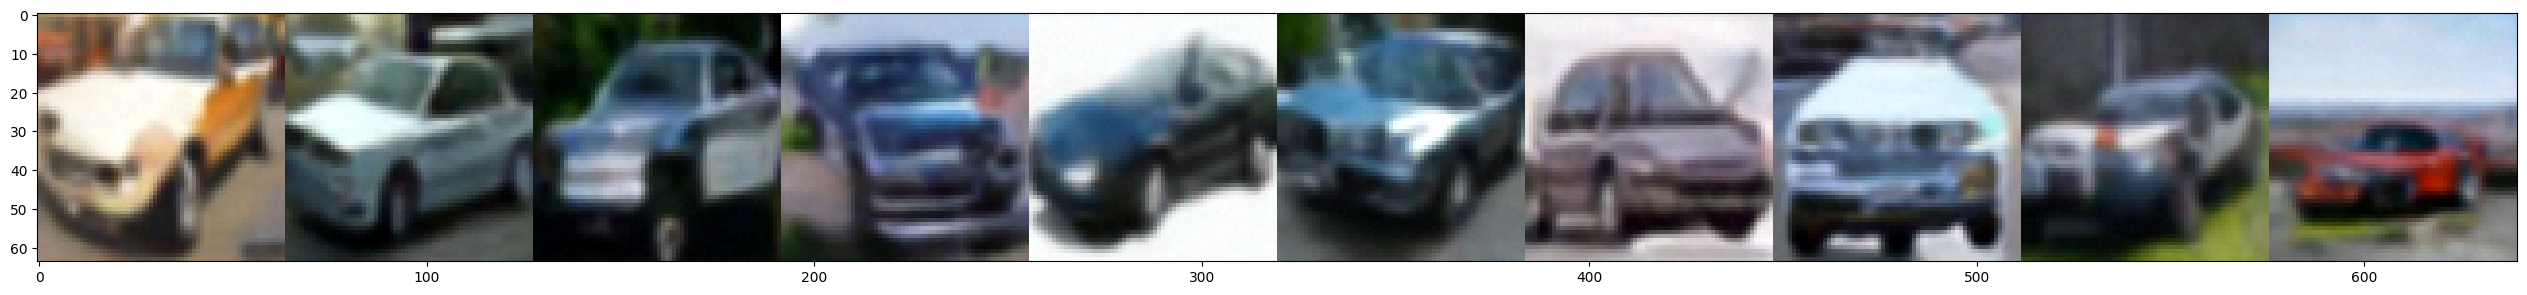

In [18]:
plot_images(samples)

In [19]:
wandb.finish()

## Log intermediate results?

In [14]:
@patch
@torch.inference_mode()
def sample_intermediate(self:Diffusion, use_ema, labels, cfg_scale=3):
    n = len(labels)
    model = self.ema_model if use_ema else self.model
    model.eval()
    with torch.inference_mode():
        x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device)
        for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
            t = (torch.ones(n) * i).long().to(self.device)
            predicted_noise = model(x, t, labels)
            if cfg_scale > 0:
                uncond_predicted_noise = model(x, t, None)
                predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            wandb.log({"gens": wandb.Image(x)})
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

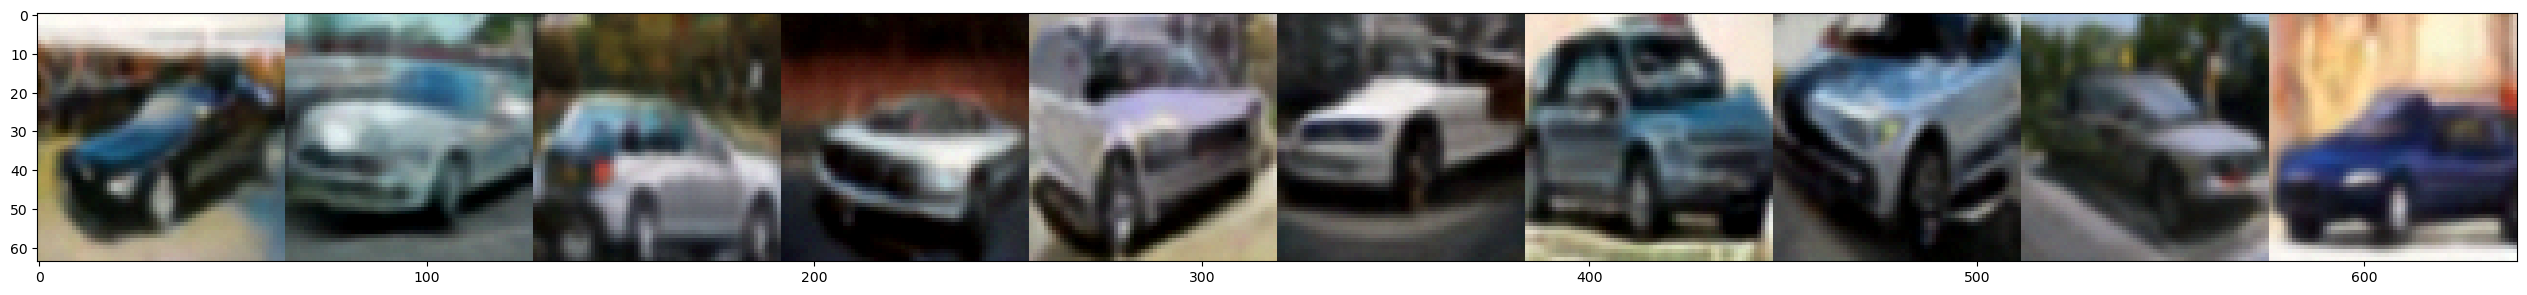

In [15]:
with wandb.init(project="train_sd", job_type="generation", config=config):
    samples = diff.sample_intermediate(True, labels=labels)
    plot_images(samples)